In [80]:
%matplotlib inline
import math
import os 
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as cl
import matplotlib.ticker as mtick
from matplotlib.gridspec import GridSpec
import statsmodels.api as sm
from pandas import ExcelWriter
import pickle
import scipy as sp
from itertools import repeat

In [81]:
def load_object(filename):
    with open(filename, 'rb') as fid:
        file = pickle.load(fid)
    return file

In [82]:
#load the codes
Qian2016codes = load_object('models/revision/Qian2016codes_2.pkl')
Qian2018codes = load_object('models/revision/Qian2018codes_2.pkl')
QianU2019codes = load_object('models/revision/QianU2019codes_2.pkl')
QianR2019codes = load_object('models/revision/QianR2019codes_2.pkl')
Sourcecodes = load_object('models/revision/Sourcecodes_2.pkl')
Sourcetrainingcodes = load_object('models/revision//Sourcesamples_trainingcodes_2.pkl')
Sourcetestingcodes = load_object('models/revision//Sourcesamples_testingcodes_2.pkl')

#Load the DFs
Qian2016DF, Qian2016prob, Qian2016keys = load_object('models/revision/Qian2016DF_2.pkl')
Qian2018DF, Qian2018prob, Qian2018keys = load_object('models/revision/Qian2018DF_2.pkl')
QianU2019DF, QianU2019prob, QianU2019keys = load_object('models/revision/QianU2019DF_2.pkl')
QianR2019DF, QianR2019prob, QianR2019keys = load_object('models/revision/QianR2019DF_2.pkl')
SourceDF, Sourceprob, Sourcekeys = load_object('models/revision/SourceDF_2.pkl')
SourcetrainingDF, Sourcetrainingprob, Sourcekeys = load_object('models/revision/SourcetrainingDF_2.pkl')
SourcetestingDF, Sourcetestingprob, Sourcekeys = load_object('models/revision/SourcetestingDF_2.pkl')

clustersdata = [Qian2016DF, Qian2018DF, QianU2019DF, QianR2019DF, SourceDF]
probdata = [Qian2016prob, Qian2018prob, QianU2019prob, QianR2019prob, Sourceprob]
airkeys = [Qian2016keys, Qian2018keys, QianU2019keys, QianR2019keys, Sourcekeys]

In [163]:
Sourcekeys

['Soil dust',
 'Construction dust',
 'Construction sand',
 'Coal burning',
 'Industrial emission',
 'Car exhaust',
 'Biomass',
 'No Sources']

In [83]:
# load urban fug dust 
Urbanfugdustcodes = load_object('models/revision/Urbfugdustcodes_2.pkl')

UrbanfugdustDF, Urbanfugdustprob, Urbanfugdustkeys = load_object('models/revision/UrbanfugdustDF_2.pkl')

In [84]:
def index(data, label):
    mini = data.reset_index()[data.reset_index()['labels'] == label].index.min()
    maxi = data.reset_index()[data.reset_index()['labels'] == label].index.max()
    return mini,maxi

## Threshold

In [88]:
tvdistance = []
for j in Sourcekeys:
    tvmid = []
    for i in Sourcekeys:
        tvmid.append(0.5*sp.spatial.distance.cdist(Sourcetestingprob[index(SourcetestingDF, j)[0]: index(SourcetestingDF, j)[1] + 1],
                                                  Sourcetrainingprob[index(SourcetrainingDF, i)[0]: index(SourcetrainingDF, i)[1] + 1], 'cityblock'))
    tvdistance.append(tvmid)

In [323]:
avglist = []
for l in tvdistance:
    avg = np.zeros([len(l[0]), 7])
    for i,j in enumerate(l):
        avg[:,i] = np.min(j, axis = 1)
    avglist.append(avg)

In [324]:
#input the distance metric of a sample point with a source
def threshold(datapoint, sourcekeys, value):
    index = np.where(datapoint < value)[0]
    if len(index) > 0:
        return [sourcekeys[i] for i in index.tolist()]
    else:
        return ['No Sources']

In [91]:
# add 'no sources' to Sourcekeys
Sourcekeys.append('No Sources')


In [329]:
avglist[0][0]

array([8.59345353e-06, 2.32871463e-05, 3.47533181e-05, 1.77914365e-04,
       9.31589003e-06, 1.18686301e-03, 6.37959157e-05])

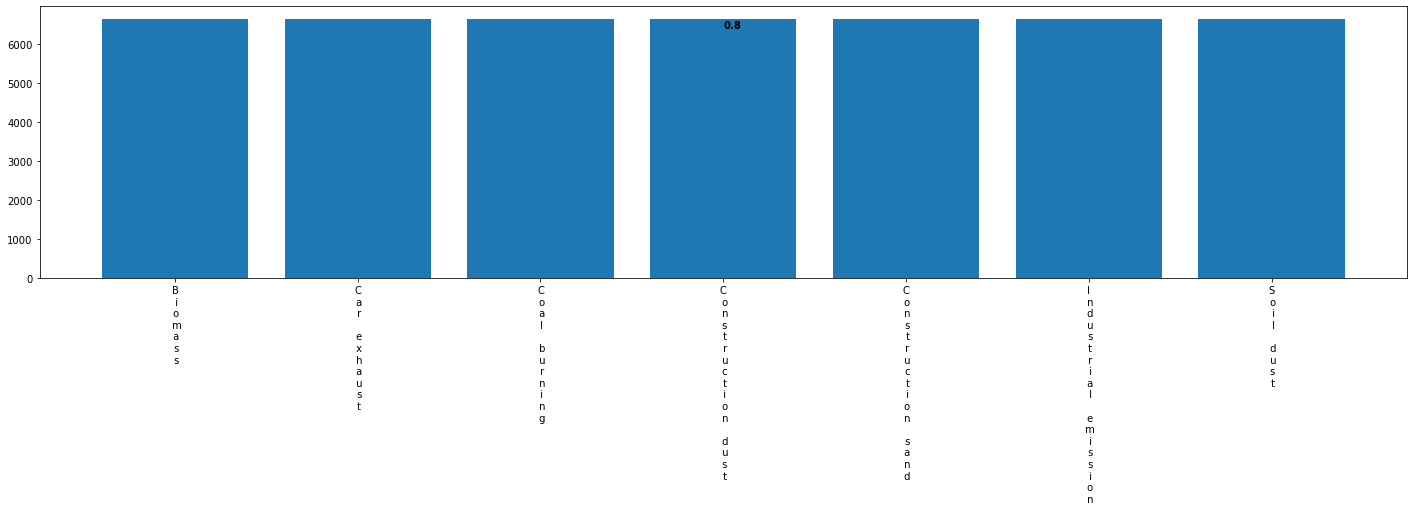

In [327]:
thresholdlist = np.arange(0.80, 0.85, 0.05)

for i in thresholdlist:
    Sourcethreslist = []
    for j in avglist[0]:
        Sourcethreslist.append(threshold(j, Sourcekeys, i))
    
    unique, uniquecounts = np.unique(np.array(Sourcethreslist, dtype = 'object'), return_counts = True)
    
    fig, ax = plt.subplots(figsize = (len(unique) * 3.5,5))
    ax.bar(np.arange(0, len(uniquecounts)), uniquecounts)
    ax.text(0.5, 0.95, i, transform=ax.transAxes,
            fontsize=10, fontweight='bold', va='top')
    ax.set_xticks(np.arange(0, len(uniquecounts)))
    ax.set_xticklabels(['\n '.join(i) for i in unique])
    plt.show()
    

In [216]:
def softclusteringparser(dataset, thresholdvalue, sourcekeys, returns = True):
    Sourcethreslist = []
    for j in dataset:
        Sourcethreslist.append(threshold(j, sourcekeys, thresholdvalue))
    
    unique, uniquecounts = np.unique(np.array(Sourcethreslist, dtype = 'object'), return_counts = True)
    
    if returns == True:
        return Sourcethreslist
    
    else:
        fig, ax = plt.subplots(figsize = (len(unique) * 3.5,5))
        ax.bar(np.arange(0, len(uniquecounts)), uniquecounts)
        ax.text(0.5, 0.95, thresholdvalue, transform=ax.transAxes,
                fontsize=10, fontweight='bold', va='top')
        ax.set_xticks(np.arange(0, len(uniquecounts)))
        ax.set_xticklabels(['\n '.join(k) for k in unique])
        plt.show()


# Analyze soil dust predicted only as soil dust. what is unique?

In [114]:
# import some handy functions

#Type: Data Frame. From a selected isotope and its particle events, select all other isotopes associated and drop others not associated with it
def isotope_particle(data, isotope):
    obs = data[data[isotope]>0.0]
    return obs

#conditional_probabilities returns out of the total selected-isotope particle events, what is the probability it is associated with the list of other isotopes 
def conditional_probabilities(data, isotope):
    obs = data[abs(data[isotope]) > 0.0]
    partners = (abs(obs) > 0.0).astype(np.float64).mean()
    return partners[abs(partners) > 0.0].sort_values(ascending=False)

#counts the total particles associated to an isotope
def conditional_particle(data, isotope):
    obs = data[abs(data[isotope]) > 0.0].count()
    return obs.sort_values(ascending=False)
    
#marginal_probabilities returns out of the total particle events, what is the probability of an individual isotope occurring
def marginal_probabilities(data):
    #return data.count().sort_values(ascending=False) / total_particles(data).sum()
    return (abs(data) > 0.0).mean().sort_values(ascending=False)

#Counts total number of peaks for each isotope
def marginal_particle(data):
    #replace 0 with nan
    data.replace(0, np.nan, inplace = True)
    return abs(data).count().sort_values(ascending=False)

#probability_pure returns out of the total selected-isotope particle events, what is the probability that it is not associated with any other isotope
def probability_pure(data, isotope):
    obs = data[data[isotope] > 0.0]
    others = obs.drop(columns=isotope)
    pure = (others.sum(axis=1) == 0.0).mean()
    return pure

#isotope_pure returns a data frame of the selected isotope particle event and its impurities
def isotope_pure(data, isotope):
    obs = data[data[isotope] > 0.0]
    others = obs.drop(columns=isotope)
    pure = others.sum(axis=1) == 0.0
    others = obs[pure]
    return others


In [347]:
Sourcethreslist = softclusteringparser(avglist[0], 0.00001, Sourcekeys, returns = True)

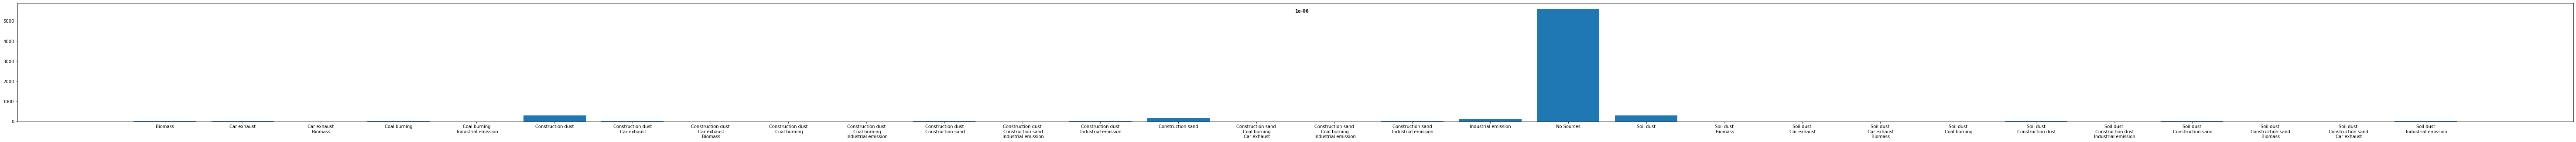

In [342]:
softclusteringparser(avglist[0], 0.000001, Sourcekeys, returns = False)

In [348]:
# Source specifically labeled and predicted as soil dust
sourcedata = SourcetestingDF[SourcetestingDF['labels'] == 'Soil dust'].iloc[[i == ['Soil dust'] for i in Sourcethreslist]].iloc[:, : -3]

originaldata = SourcetestingDF[SourcetestingDF['labels'] == 'Soil dust'].iloc[:, : -3]

In [349]:
marginal_particle(sourcedata)

48Ti     302
55Mn     156
54Fe     147
138Ba     37
90Zr      31
140Ce     25
139La     18
88Sr      12
85Rb       9
51V        6
59Co       5
58Ni       5
208Pb      4
89Y        4
93Nb       3
69Ga       2
52Cr       1
72Ge       1
78Se       0
193Ir      0
195Pt      0
197Au      0
180Hf      0
75As       0
108Pd      0
64Zn       0
63Cu       0
202Hg      0
98Mo       0
107Ag      0
175Lu      0
153Eu      0
174Yb      0
169Tm      0
166Er      0
165Ho      0
164Dy      0
159Tb      0
158Gd      0
152Sm      0
114Cd      0
181Ta      0
185Re      0
192Os      0
238U       0
130Te      0
121Sb      0
120Sn      0
133Cs      0
dtype: int64

<ipython-input-220-6824c2d3354e>:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  total = np.array(total)


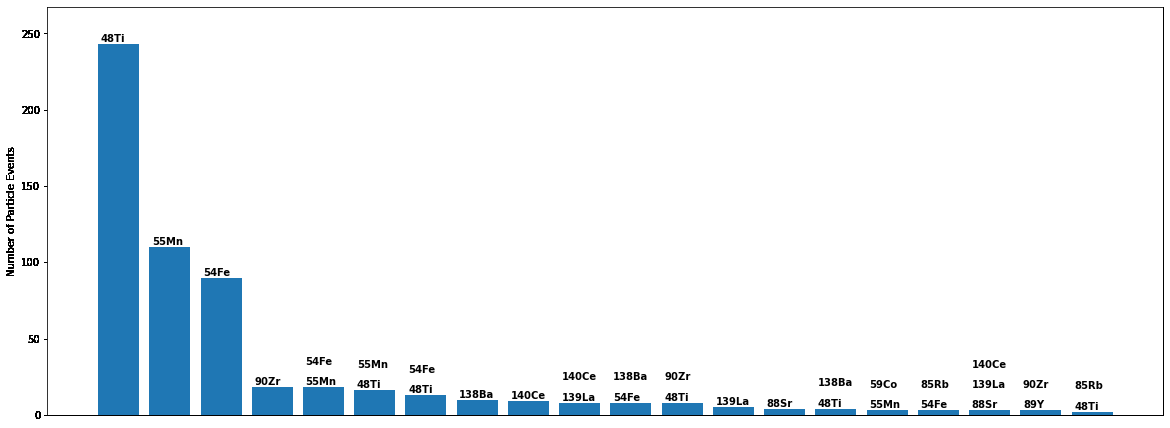

In [350]:
fig = plt.figure(figsize = (20,7.5))

aggregate= aggregate_particles(sourcedata)[0:20]
y = aggregate['Value'].values
ylabels = []
for i in aggregate.index:
    ylabels.append(i.split('+'))
ylabels1 = []
for i in ylabels:
    ylabels1.append(np.array(i).reshape(len(i),1))
    ax = fig.subplots()
    width = 0.75
    ind = np.arange(len(y))
    ax.bar(ind, aggregate['Value'])
    ax.set_xticks([])
    try:
        yceiling = aggregate['Value'][0]*1.10
        ax.set_ylim(0, yceiling)
        ax.set_ylabel('Number of Particle Events')

        for i, v in enumerate(y):
            for j in range(0,len(ylabels1[i])):
                ax.text(i - .35, v + yceiling/200 + j*yceiling/20, str(str(str(ylabels1[i][j]).replace("'", '')).replace("[", '')).replace("]", ''), fontweight='bold')
    except IndexError:
        continue

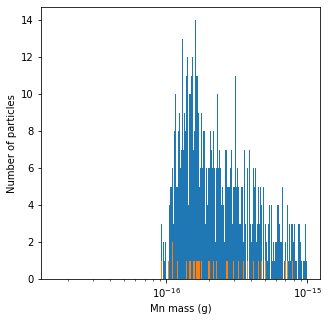

In [345]:
#Mass distribution for each analyte
bins = 10**(np.arange(-16.8,-15, .005).astype('float'))

fig = plt.figure(figsize = (5,5))
ax = fig.subplots()
ax.hist(isotope_pure(originaldata, '55Mn')['55Mn'], bins = bins)
ax.hist(sourcedata['55Mn'], bins = bins)
ax.set_xlabel('Mn mass (g)')
ax.set_ylabel('Number of particles')
ax.set_xscale('log')
plt.show()

In [137]:
# Source labeled soil dust and predicted as soil dust construction dust and construction sand
sourcedata = SourcetestingDF[SourcetestingDF['labels'] == 'Soil dust'].iloc[[i == ['Soil dust', 'Construction dust', 'Construction sand'] for i in Sourcethreslist]].iloc[:, : -3]

originaldata = SourcetestingDF[SourcetestingDF['labels'] == 'Soil dust'].iloc[:, : -3]

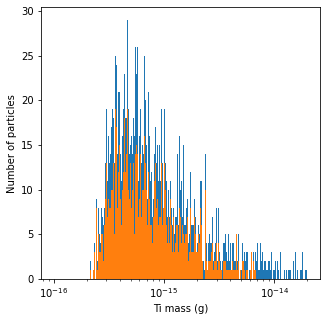

In [145]:
#Mass distribution for each analyte
bins = 10**(np.arange(-16,-13.7, .005).astype('float'))

fig = plt.figure(figsize = (5,5))
ax = fig.subplots()
ax.hist(originaldata['48Ti'], bins = bins)
ax.hist(sourcedata['48Ti'], bins = bins)
ax.set_xlabel('Ti mass (g)')
ax.set_ylabel('Number of particles')
ax.set_xscale('log')
plt.show()

In [146]:
# Source labeled soil dust and predicted as soil dust construction dust and construction sand
sourcedata = SourcetestingDF[SourcetestingDF['labels'] == 'Soil dust'].iloc[[i == ['Soil dust', 'Construction dust'] for i in Sourcethreslist]].iloc[:, : -3]

originaldata = SourcetestingDF[SourcetestingDF['labels'] == 'Soil dust'].iloc[:, : -3]

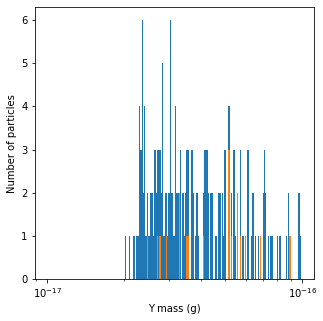

In [159]:
#Mass distribution for each analyte
bins = 10**(np.arange(-17,-16, .005).astype('float'))

fig = plt.figure(figsize = (5,5))
ax = fig.subplots()
ax.hist(originaldata['89Y'], bins = bins)
ax.hist(sourcedata['89Y'], bins = bins)
ax.set_xlabel('Y mass (g)')
ax.set_ylabel('Number of particles')
ax.set_xscale('log')
plt.show()

# Soft clustering coal burning

In [211]:
Sourcethreslist = softclusteringparser(avglist[3], 0.95, Sourcekeys)

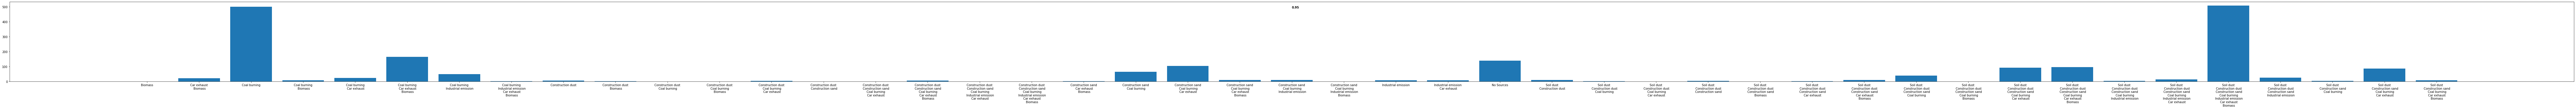

In [217]:
softclusteringparser(avglist[3], 0.95, Sourcekeys, returns = False)

In [218]:
# Source specifically labeled and predicted as soil dust
sourcedata = SourcetestingDF[SourcetestingDF['labels'] == 'Coal burning'].iloc[[i == ['Coal burning'] for i in Sourcethreslist]].iloc[:, : -3]

originaldata = SourcetestingDF[SourcetestingDF['labels'] == 'Coal burning'].iloc[:, : -3]

In [219]:
marginal_particle(sourcedata)

208Pb    543
138Ba      1
88Sr       1
51V        0
78Se       0
114Cd      0
107Ag      0
108Pd      0
98Mo       0
93Nb       0
90Zr       0
89Y        0
85Rb       0
75As       0
121Sb      0
72Ge       0
69Ga       0
64Zn       0
63Cu       0
58Ni       0
59Co       0
54Fe       0
55Mn       0
52Cr       0
120Sn      0
133Cs      0
130Te      0
174Yb      0
202Hg      0
197Au      0
195Pt      0
193Ir      0
192Os      0
185Re      0
181Ta      0
180Hf      0
175Lu      0
169Tm      0
238U       0
166Er      0
165Ho      0
164Dy      0
159Tb      0
158Gd      0
153Eu      0
152Sm      0
140Ce      0
139La      0
48Ti       0
dtype: int64

In [220]:
#returns aggregate particles of a dataset
def aggregate_particles(data, element1 = None):
    total = []
    #go through each row
    for i in data.itertuples():
        labels = []
        #in that row, go through each element
        for j in range(1, len(i)):
            #if there is some value
            if i[j] > 0:
                #append the element into the labels list
                labels.append(data.columns[j - 1])
                #if there is no elements
                if labels[-1] == None:
                    print('ERROR')
        #if there are some elements in the labels list
        if labels != []:
            #append it to the total list
            total.append(labels)
    #make an array of this
    total = np.array(total)
    #only find the unique labels
    uniquelist = np.unique(total)
    
    
    #if element1 is there, focus on that one element
    if element1 != None:
        uniquelist = uniquelist[[element1 in i for i in uniquelist]]
        
    uniquelist1 = []
    #for each unique label
    for i in uniquelist:
        #join them together with a + sign
        uniquelist1.append('+'.join(i))
    totalvalue = []
    # for each unique label
    for i in uniquelist:
        value = 0
        # for each label in total
        for j in total:
            if i == j:
                #count how many there are
                value = value + 1
        totalvalue.append(value)

    finaldf = pd.DataFrame(totalvalue, uniquelist1, columns = ['Value']).sort_values('Value', ascending = False)
    return finaldf

<ipython-input-220-6824c2d3354e>:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  total = np.array(total)


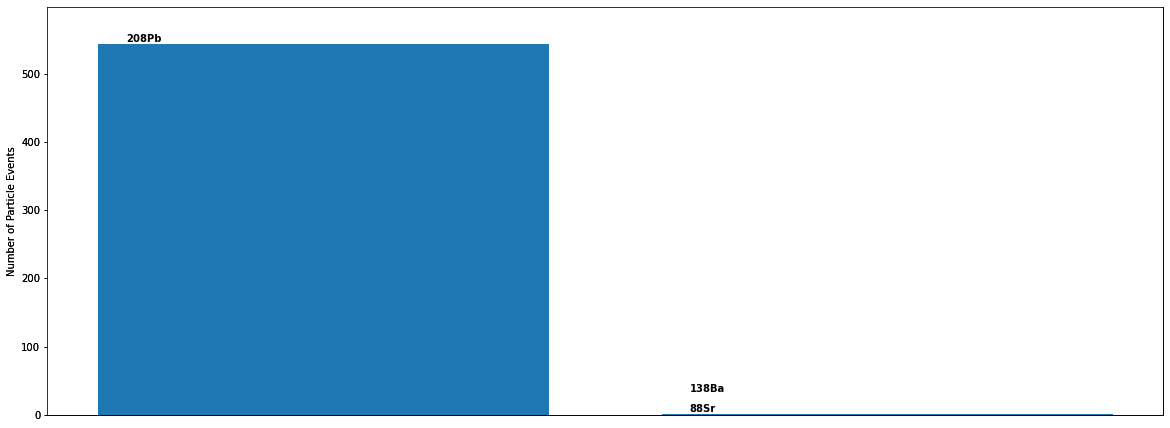

In [221]:
fig = plt.figure(figsize = (20,7.5))

aggregate= aggregate_particles(sourcedata)[0:20]
y = aggregate['Value'].values
ylabels = []
for i in aggregate.index:
    ylabels.append(i.split('+'))
ylabels1 = []
for i in ylabels:
    ylabels1.append(np.array(i).reshape(len(i),1))
    ax = fig.subplots()
    width = 0.75
    ind = np.arange(len(y))
    ax.bar(ind, aggregate['Value'])
    ax.set_xticks([])
    try:
        yceiling = aggregate['Value'][0]*1.10
        ax.set_ylim(0, yceiling)
        ax.set_ylabel('Number of Particle Events')

        for i, v in enumerate(y):
            for j in range(0,len(ylabels1[i])):
                ax.text(i - .35, v + yceiling/200 + j*yceiling/20, str(str(str(ylabels1[i][j]).replace("'", '')).replace("[", '')).replace("]", ''), fontweight='bold')
    except IndexError:
        continue

In [204]:
aggregate['Value'][0]

543

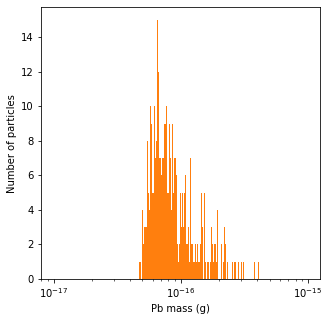

In [189]:
#Mass distribution for each analyte
bins = 10**(np.arange(-17,-15, .005).astype('float'))

fig = plt.figure(figsize = (5,5))
ax = fig.subplots()
ax.hist(isotope_pure(originaldata, '208Pb')['208Pb'], bins = bins)
ax.hist(isotope_pure(sourcedata, '208Pb')['208Pb'], bins = bins)
ax.set_xlabel('Pb mass (g)')
ax.set_ylabel('Number of particles')
ax.set_xscale('log')
plt.show()

# Soft clustering industrial emission

In [262]:
Sourcethreslist = softclusteringparser(avglist[4], 0.95, Sourcekeys)

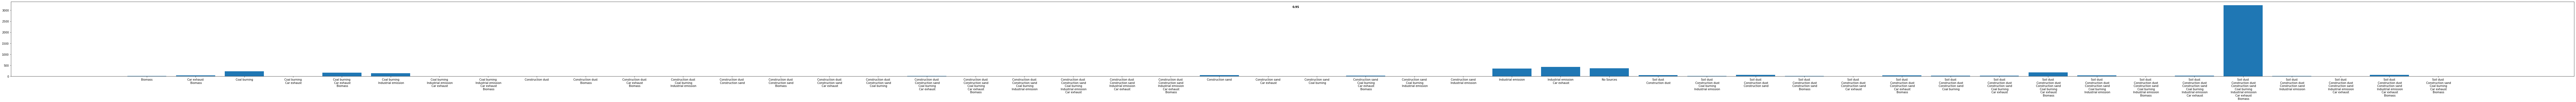

In [263]:
softclusteringparser(avglist[4], 0.95, Sourcekeys, returns = False)

In [264]:
# Source specifically labeled and predicted as soil dust
sourcedata = SourcetestingDF[SourcetestingDF['labels'] == 'Industrial emission'].iloc[[i == ['Industrial emission'] for i in Sourcethreslist]].iloc[:, : -3]

originaldata = SourcetestingDF[SourcetestingDF['labels'] == 'Industrial emission'].iloc[:, : -3]

<ipython-input-220-6824c2d3354e>:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  total = np.array(total)


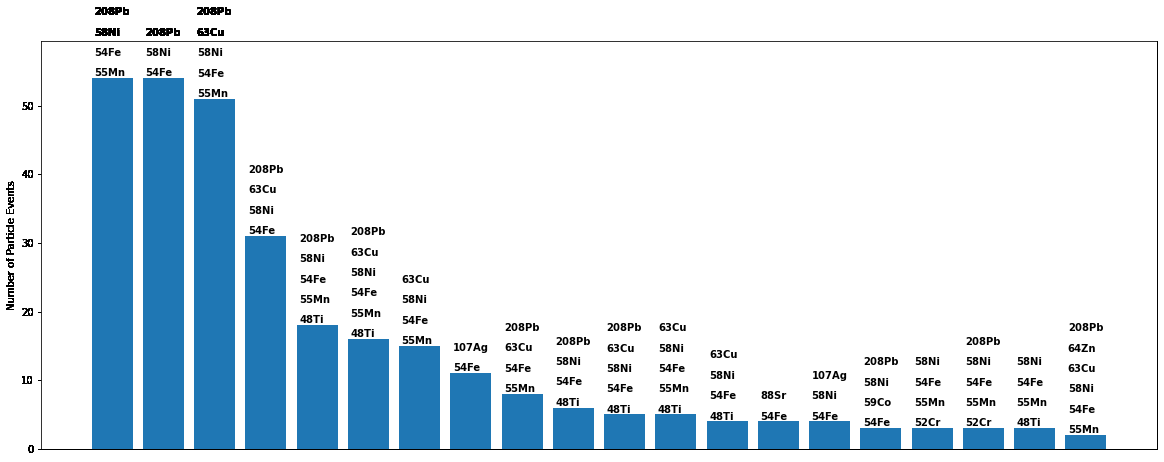

In [265]:
fig = plt.figure(figsize = (20,7.5))

aggregate= aggregate_particles(sourcedata)[0:20]
y = aggregate['Value'].values
ylabels = []
for i in aggregate.index:
    ylabels.append(i.split('+'))
ylabels1 = []
for i in ylabels:
    ylabels1.append(np.array(i).reshape(len(i),1))
    ax = fig.subplots()
    width = 0.75
    ind = np.arange(len(y))
    ax.bar(ind, aggregate['Value'])
    ax.set_xticks([])
    try:
        yceiling = aggregate['Value'][0]*1.10
        ax.set_ylim(0, yceiling)
        ax.set_ylabel('Number of Particle Events')

        for i, v in enumerate(y):
            for j in range(0,len(ylabels1[i])):
                ax.text(i - .35, v + yceiling/200 + j*yceiling/20, str(str(str(ylabels1[i][j]).replace("'", '')).replace("[", '')).replace("]", ''), fontweight='bold')
    except IndexError:
        continue

# Soft clustering car exhaust

In [302]:
Sourcethreslist = softclusteringparser(avglist[5], 0.95, Sourcekeys)

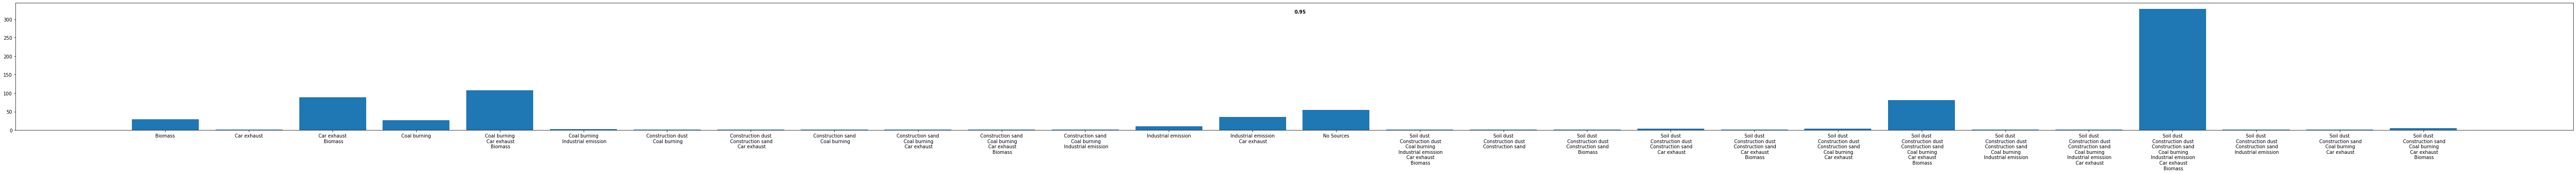

In [303]:
softclusteringparser(avglist[5], 0.95, Sourcekeys, returns = False)

In [304]:
# Source specifically labeled and predicted as soil dust
sourcedata = SourcetestingDF[SourcetestingDF['labels'] == 'Car exhaust'].iloc[[i == ['Car exhaust'] for i in Sourcethreslist]].iloc[:, : -3]

originaldata = SourcetestingDF[SourcetestingDF['labels'] == 'Car exhaust'].iloc[:, : -3]

In [305]:
marginal_particle(sourcedata)

208Pb    2
138Ba    2
51V      0
78Se     0
114Cd    0
107Ag    0
108Pd    0
98Mo     0
93Nb     0
90Zr     0
89Y      0
88Sr     0
85Rb     0
75As     0
121Sb    0
72Ge     0
69Ga     0
64Zn     0
63Cu     0
58Ni     0
59Co     0
54Fe     0
55Mn     0
52Cr     0
120Sn    0
133Cs    0
130Te    0
174Yb    0
202Hg    0
197Au    0
195Pt    0
193Ir    0
192Os    0
185Re    0
181Ta    0
180Hf    0
175Lu    0
169Tm    0
238U     0
166Er    0
165Ho    0
164Dy    0
159Tb    0
158Gd    0
153Eu    0
152Sm    0
140Ce    0
139La    0
48Ti     0
dtype: int64

In [290]:
Sourcethreslist

[['Soil dust',
  'Construction sand',
  'Industrial emission',
  'Car exhaust',
  'Biomass'],
 ['Construction sand'],
 ['Construction sand'],
 ['No Sources'],
 ['No Sources'],
 ['No Sources'],
 ['Soil dust', 'Construction dust', 'Construction sand'],
 ['Construction sand', 'Industrial emission'],
 ['No Sources'],
 ['No Sources'],
 ['Soil dust', 'Construction dust', 'Construction sand'],
 ['Construction sand', 'Industrial emission'],
 ['No Sources'],
 ['No Sources'],
 ['Soil dust', 'Industrial emission'],
 ['No Sources'],
 ['No Sources'],
 ['No Sources'],
 ['No Sources'],
 ['Soil dust', 'Construction dust', 'Construction sand'],
 ['No Sources'],
 ['No Sources'],
 ['No Sources'],
 ['Construction sand'],
 ['Soil dust',
  'Construction sand',
  'Industrial emission',
  'Car exhaust',
  'Biomass'],
 ['No Sources'],
 ['Soil dust', 'Industrial emission'],
 ['Construction sand'],
 ['No Sources'],
 ['Soil dust',
  'Construction dust',
  'Construction sand',
  'Industrial emission',
  'Car exhau

# Soft clustering Biomass

In [319]:
Sourcethreslist = softclusteringparser(avglist[6], 0.98, Sourcekeys)

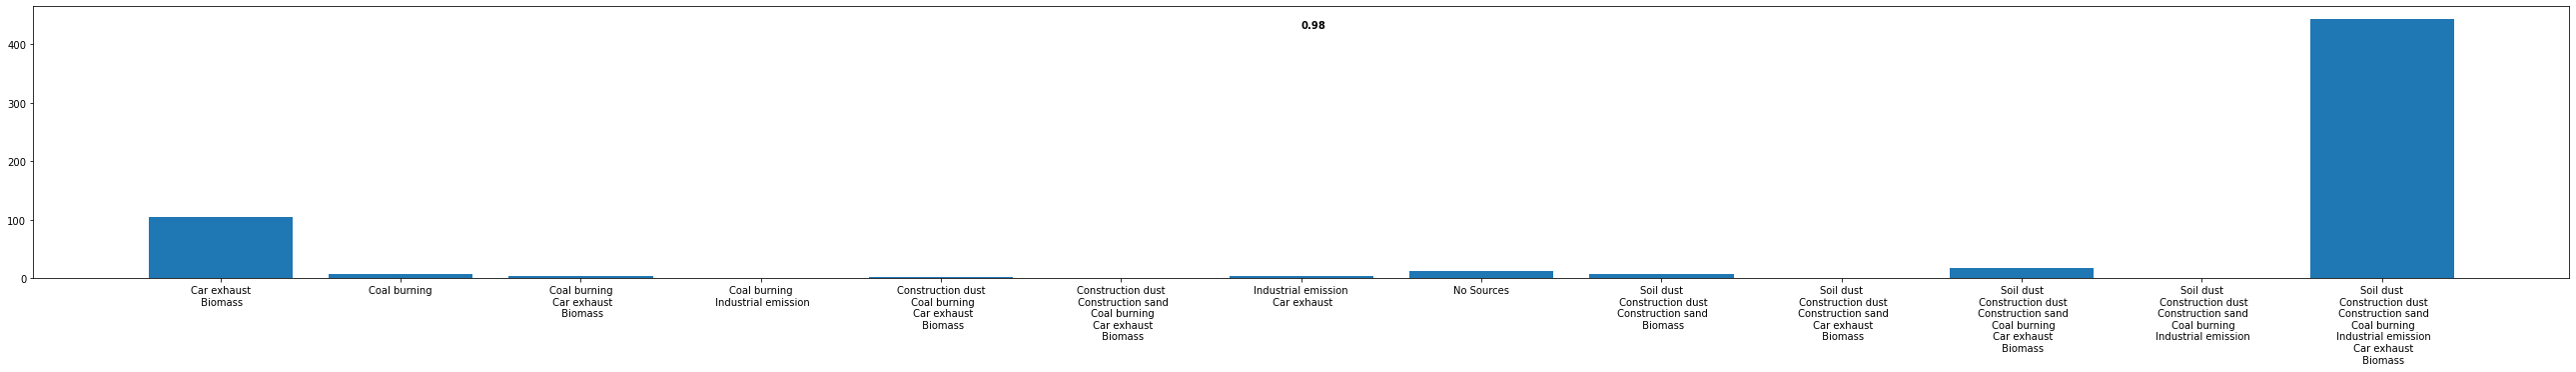

In [320]:
softclusteringparser(avglist[6], 0.98, Sourcekeys, returns = False)

In [321]:
# Source specifically labeled and predicted as soil dust
sourcedata = SourcetestingDF[SourcetestingDF['labels'] == 'Biomass'].iloc[[i == ['Biomass'] for i in Sourcethreslist]].iloc[:, : -3]

originaldata = SourcetestingDF[SourcetestingDF['labels'] == 'Biomass'].iloc[:, : -3]

In [322]:
marginal_particle(sourcedata)

51V      0
130Te    0
120Sn    0
114Cd    0
107Ag    0
108Pd    0
98Mo     0
93Nb     0
90Zr     0
89Y      0
88Sr     0
85Rb     0
78Se     0
75As     0
72Ge     0
69Ga     0
64Zn     0
63Cu     0
58Ni     0
59Co     0
54Fe     0
55Mn     0
52Cr     0
121Sb    0
133Cs    0
238U     0
138Ba    0
208Pb    0
202Hg    0
197Au    0
195Pt    0
193Ir    0
192Os    0
185Re    0
181Ta    0
180Hf    0
175Lu    0
174Yb    0
169Tm    0
166Er    0
165Ho    0
164Dy    0
159Tb    0
158Gd    0
153Eu    0
152Sm    0
140Ce    0
139La    0
48Ti     0
dtype: int64